# 7. PPO
TRPO 算法在很多场景上的应用都很成功，但是我们也发现它的计算过程非常复杂，每一步更新的运算量非常大。于是，TRPO 算法的改进版——PPO 算法在 2017 年被提出，PPO 基于 TRPO 的思想，但是其算法实现更加简单。并且大量的实验结果表明，与 TRPO 相比，PPO 能学习得一样好（甚至更快），这使得 PPO 成为非常流行的强化学习算法。如果我们想要尝试在一个新的环境中使用强化学习算法，那么 PPO 就属于可以首先尝试的算法。

### PPO-Penalty
   
不再使用带约束的目标函数，而是将新旧策略的KL散度作为一个惩罚项加入目标函数。
$$
  L_{PENALTY}(\theta) = \hat{\mathbb{E}}_t \left[ r_t(\theta) \hat{A}_t - \beta \cdot \text{KL}[\pi_{\theta_{old}}(\cdot|s_t), \pi_\theta(\cdot|s_t)] \right]
$$
  - $\beta$ 是惩罚系数，会根据实际KL散度与目标KL散度的差距进行自动调整。
  - $\text{KL}[\cdot, \cdot]$ 是衡量新旧两个策略分布差异的KL散度。  

### PPO-Clip

通过`clip`函数，**硬性地**将新旧策略的概率比率 `r(θ)` 限制在一个预先设定的“信任”小区间 `[1-ε, 1+ε]` 内。

$$
  L_{CLIP}(\theta) = \hat{\mathbb{E}}_t \left[ \min \left( r_t(\theta) \hat{A}_t, \ \text{clip}(r_t(\theta), 1-\epsilon, 1+\epsilon) \hat{A}_t \right) \right]
$$
  - $r_t(\theta) = \frac{\pi_\theta(a_t|s_t)}{\pi_{\theta_{old}}(a_t|s_t)}$ 是新旧策略的概率比。
  - $\hat{A}_t$ 是优势函数。
  - $\text{clip}(r_t(\theta), 1-\epsilon, 1+\epsilon)$ = $max(min(r_t(\theta), 1+\epsilon),1-\epsilon)$, 将$r_t(\theta)$限制在$[1-\epsilon,1+\epsilon]$之间。
  - $\epsilon$ 是一个很小的超参数，用于定义裁剪范围 (通常设为 0.1 或 0.2)。
  - 如果$\hat{A}_t>0$, 会增大$r_t(\theta)$但会限制其不超过$1+\epsilon$; 如果$\hat{A}_t<0$, 会减小$r_t(\theta)$但会限制其不低于$1-\epsilon$。


In [2]:
import gymnasium as gym
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import rl_utils

In [3]:
class PolicyNet(torch.nn.Module):
    '''策略网络'''
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=1)    # 输出动作概率


class ValueNet(torch.nn.Module):
    '''价值网络'''
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)  # 输出状态价值


class PPO:
    ''' PPO-clip '''
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                 lmbda, epochs, eps, gamma, device):
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),
                                                lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),
                                                 lr=critic_lr)
        self.gamma = gamma
        self.lmbda = lmbda
        self.epochs = epochs  # 一条序列的数据用来训练轮数
        self.eps = eps  # PPO中截断范围的参数
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        probs = self.actor(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(
            self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)
        td_target = rewards + self.gamma * self.critic(next_states) * (1 -
                                                                       dones)
        td_delta = td_target - self.critic(states)
        # 计算泛化优势估计GAE
        advantage = rl_utils.compute_advantage(self.gamma, self.lmbda,
                                               td_delta.cpu()).to(self.device)
        # 计算并分离旧策略的对数概率
        old_log_probs = torch.log(self.actor(states).gather(1,
                                                            actions)).detach()

        # 使用同一批采样数据，进行self.epochs次的循环更新
        for _ in range(self.epochs):
            # self.actor 的参数在每次迭代后都会被更新
            # 这一行使用更新后的Actor网络，计算同一批动作的对数概率
            log_probs = torch.log(self.actor(states).gather(1, actions))

            # 计算新旧策略的概率比值
            ratio = torch.exp(log_probs - old_log_probs)

            # 计算代理目标1: r(θ) * A_t
            surr1 = ratio * advantage

            # 计算代理目标2: clip函数 clip(r(θ), 1-ε, 1+ε) * A_t
            surr2 = torch.clamp(ratio, 1 - self.eps,
                                1 + self.eps) * advantage  # 截断
            
            # 逐元素地取surr1和surr2中较小的值
            # pytorch优化器只能最小化损失函数 所以这里取负号
            actor_loss = torch.mean(-torch.min(surr1, surr2))
            # 损失的来源是Critic对当前状态的价值预测
            critic_loss = torch.mean(
                F.mse_loss(self.critic(states), td_target.detach()))
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()
            actor_loss.backward()
            critic_loss.backward()
            self.actor_optimizer.step()
            self.critic_optimizer.step()

In [6]:
actor_lr = 1e-3
critic_lr = 1e-2
num_episodes = 1000
hidden_dim = 128
gamma = 0.98
lmbda = 0.95
epochs = 10
eps = 0.2
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

env_name = 'CartPole-v1'    # 车杆环境（离散）
env = gym.make(env_name)
env.reset(seed=0)
torch.manual_seed(0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = PPO(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, lmbda,
            epochs, eps, gamma, device)

return_list = rl_utils.train_on_policy_agent(env, agent, num_episodes)

Iteration 9: 100%|██████████| 100/100 [00:03<00:00, 28.01it/s, episode=1000, return=500.000]


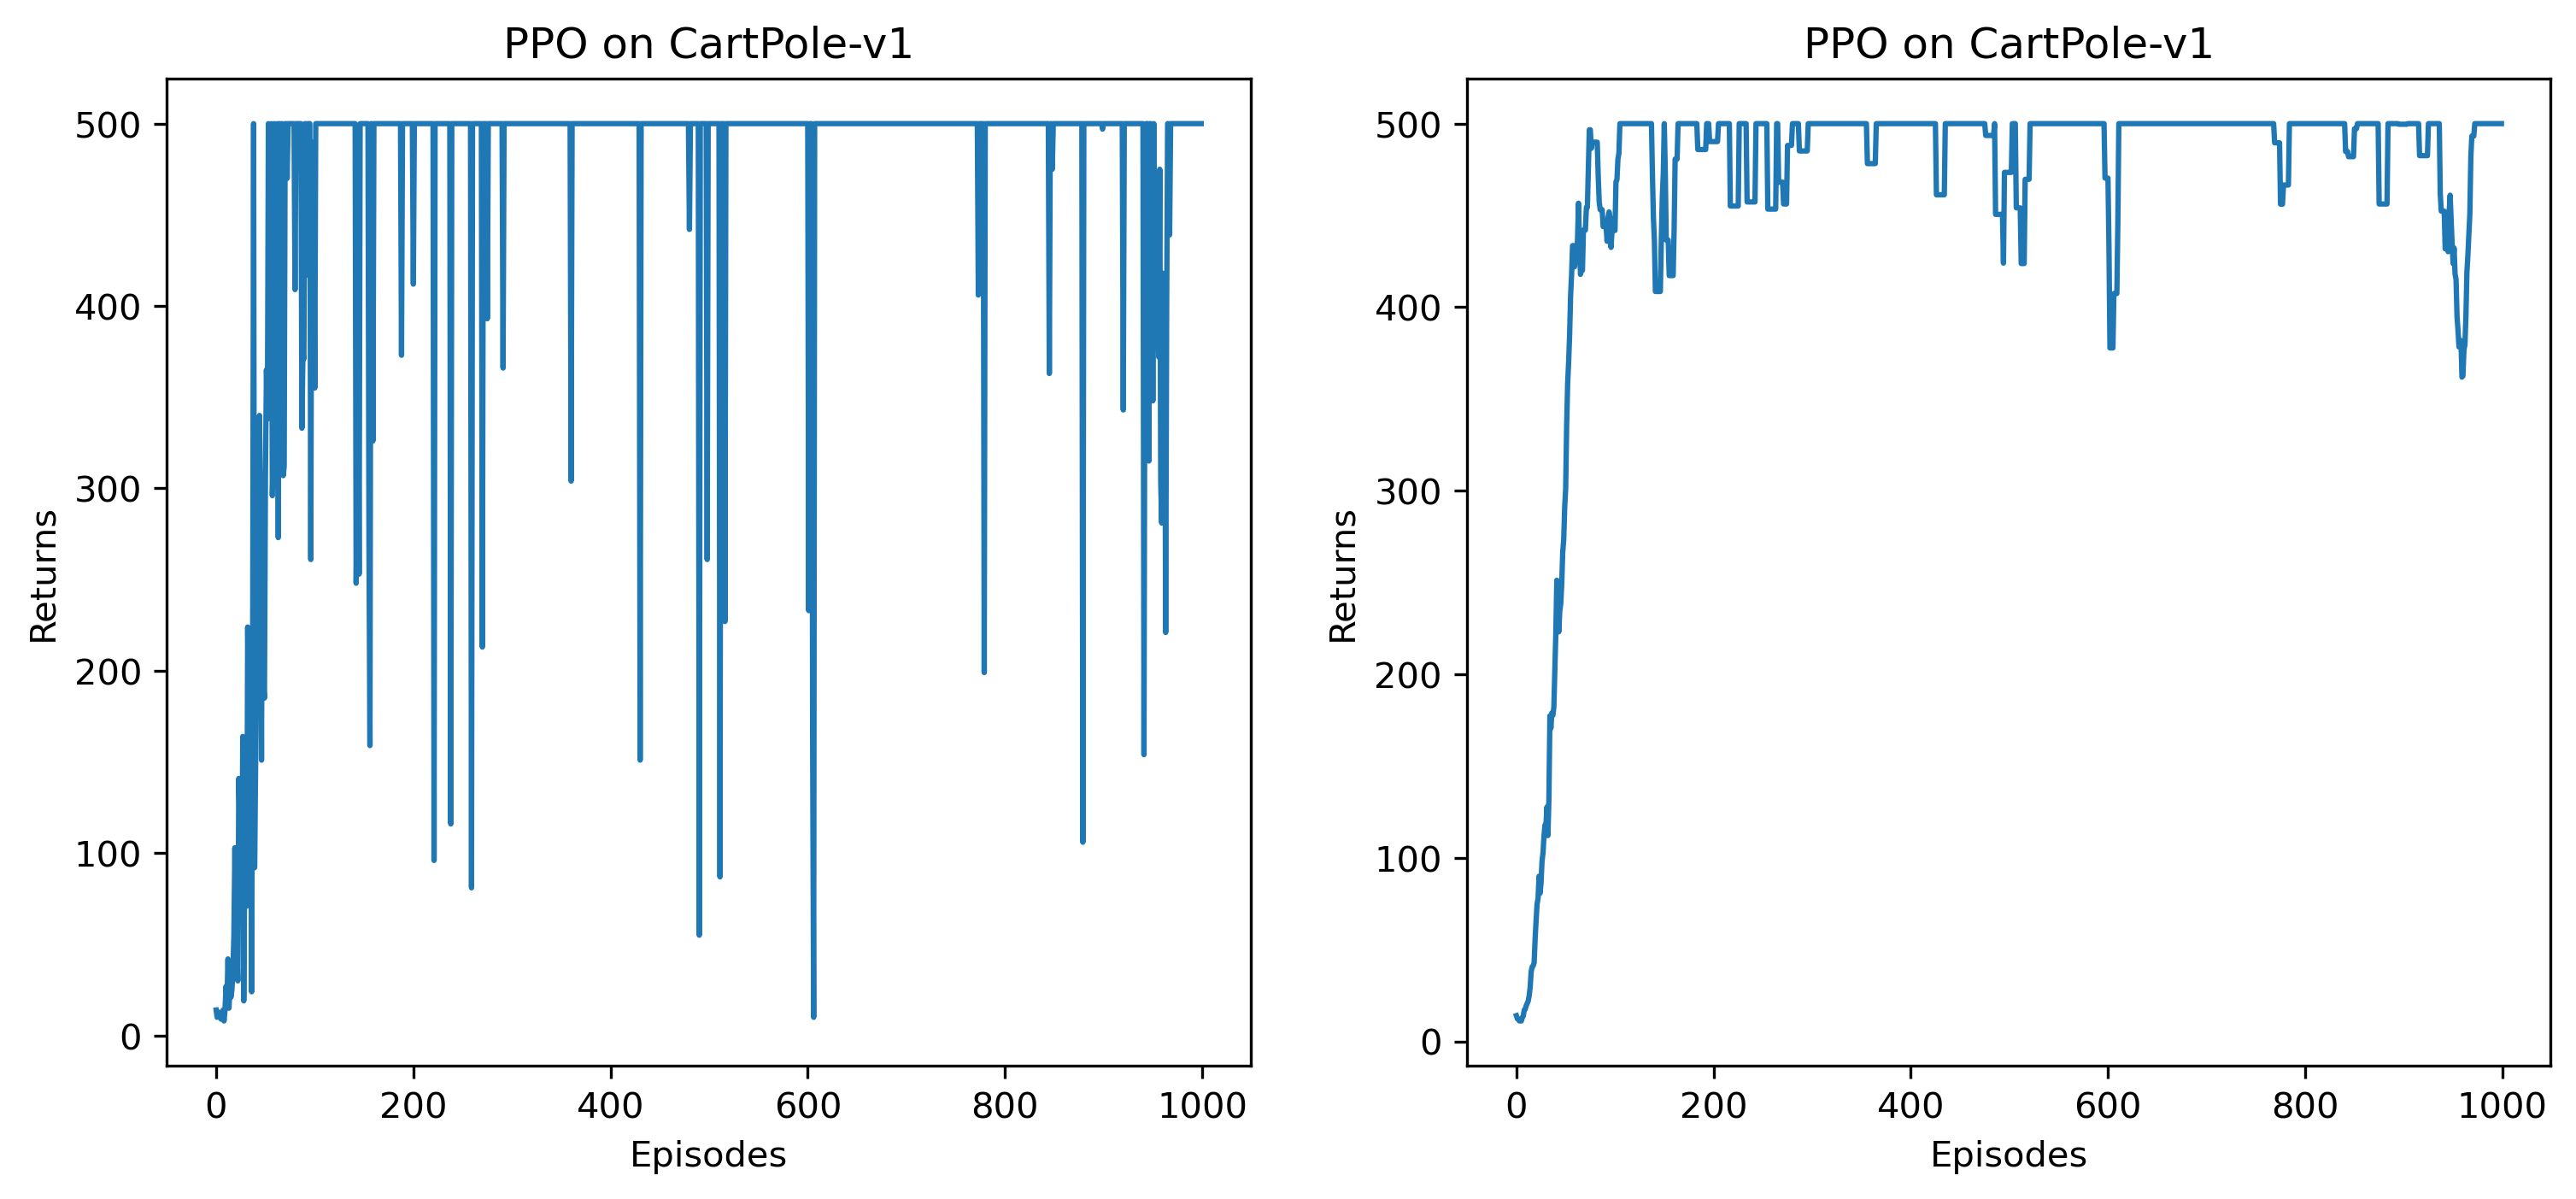

In [7]:
episodes_list = list(range(len(return_list)))
mv_return = rl_utils.moving_average(return_list, 9)

plt.figure(figsize=(12,5), dpi = 300)
plt.subplot(1,2,1)
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format(env_name))

plt.subplot(1,2,2)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format(env_name))
plt.show()

In [8]:
class PolicyNetContinuous(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNetContinuous, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc_mu = torch.nn.Linear(hidden_dim, action_dim)
        self.fc_std = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        mu = 2.0 * torch.tanh(self.fc_mu(x))
        std = F.softplus(self.fc_std(x))
        return mu, std


class PPOContinuous:
    ''' 处理连续动作的PPO算法 '''
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                 lmbda, epochs, eps, gamma, device):
        self.actor = PolicyNetContinuous(state_dim, hidden_dim,
                                         action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),
                                                lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),
                                                 lr=critic_lr)
        self.gamma = gamma
        self.lmbda = lmbda
        self.epochs = epochs
        self.eps = eps
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        mu, sigma = self.actor(state)
        action_dist = torch.distributions.Normal(mu, sigma)
        action = action_dist.sample()
        return [action.item()]

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)
        rewards = (rewards + 8.0) / 8.0  # 和TRPO一样,对奖励进行修改,方便训练
        td_target = rewards + self.gamma * self.critic(next_states) * (1 -
                                                                       dones)
        td_delta = td_target - self.critic(states)
        advantage = rl_utils.compute_advantage(self.gamma, self.lmbda,
                                               td_delta.cpu()).to(self.device)
        mu, std = self.actor(states)
        action_dists = torch.distributions.Normal(mu.detach(), std.detach())
        # 动作是正态分布
        old_log_probs = action_dists.log_prob(actions)

        for _ in range(self.epochs):
            mu, std = self.actor(states)
            action_dists = torch.distributions.Normal(mu, std)
            log_probs = action_dists.log_prob(actions)
            ratio = torch.exp(log_probs - old_log_probs)
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1 - self.eps, 1 + self.eps) * advantage
            actor_loss = torch.mean(-torch.min(surr1, surr2))
            critic_loss = torch.mean(
                F.mse_loss(self.critic(states), td_target.detach()))
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()
            actor_loss.backward()
            critic_loss.backward()
            self.actor_optimizer.step()
            self.critic_optimizer.step()

In [11]:
actor_lr = 1e-4
critic_lr = 5e-3
num_episodes = 2000
hidden_dim = 128
gamma = 0.9
lmbda = 0.9
epochs = 10
eps = 0.2
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

env_name = 'Pendulum-v1'
env = gym.make(env_name)
env.reset(seed=0)
torch.manual_seed(0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]  # 连续动作空间
agent = PPOContinuous(state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                      lmbda, epochs, eps, gamma, device)

return_list = rl_utils.train_on_policy_agent(env, agent, num_episodes)

Iteration 9: 100%|██████████| 200/200 [00:03<00:00, 61.44it/s, episode=2000, return=-310.477]


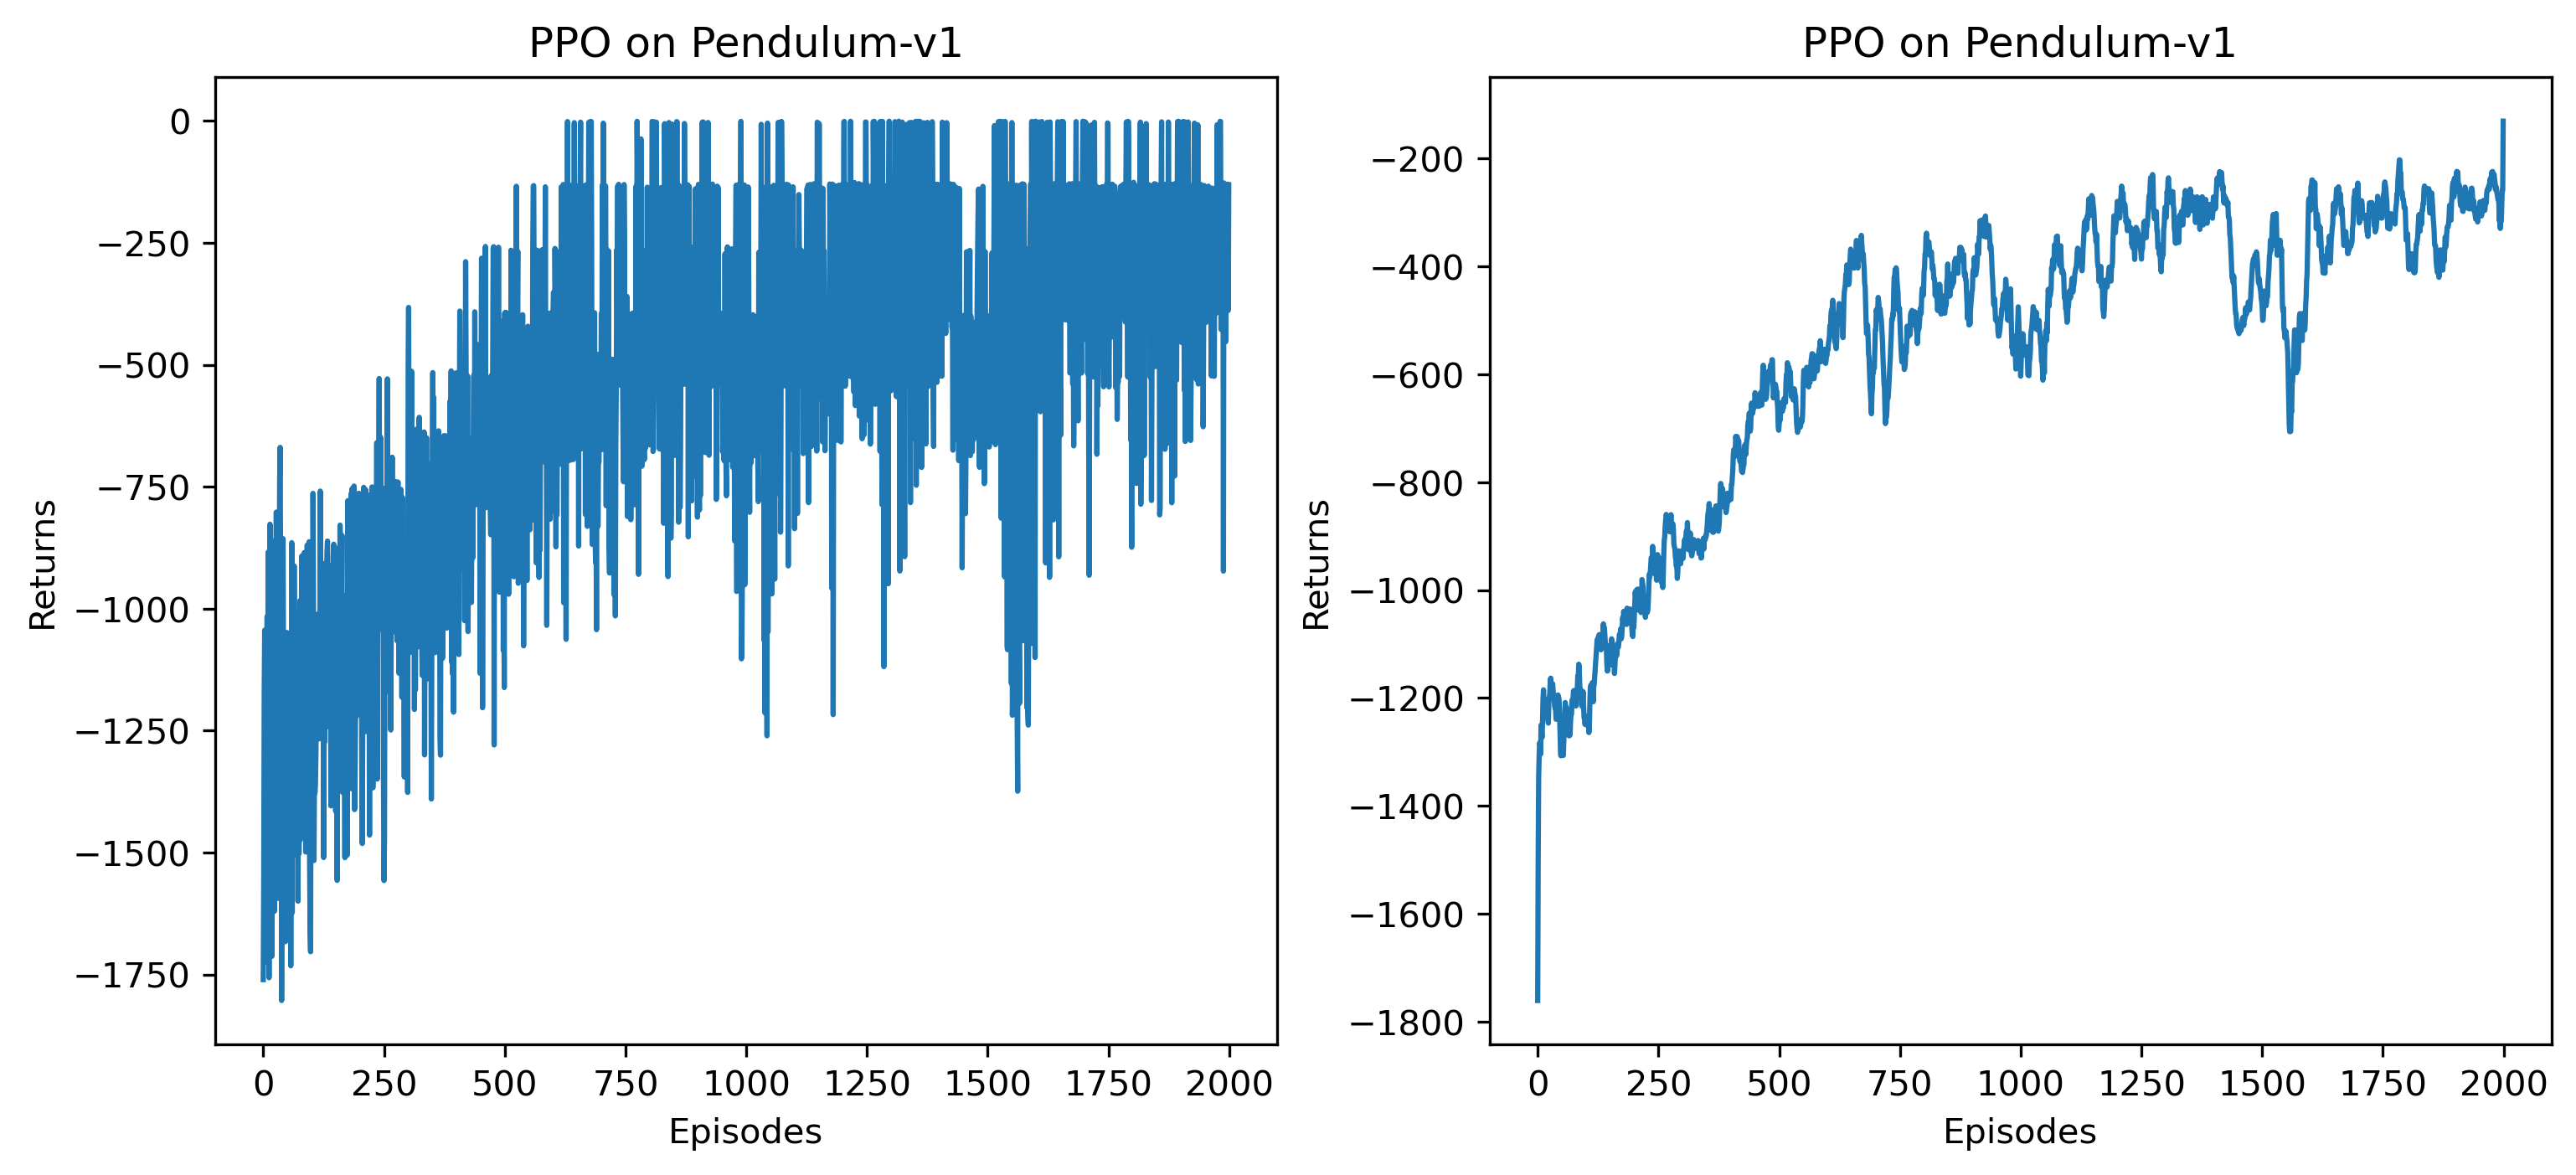

In [12]:
episodes_list = list(range(len(return_list)))
mv_return = rl_utils.moving_average(return_list, 21)
plt.figure(figsize = (12,5), dpi = 300)
plt.subplot(1,2,1)
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format(env_name))

plt.subplot(1,2,2)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format(env_name))
plt.show()

PPO 是 TRPO 的一种改进算法，它在实现上简化了 TRPO 中的复杂计算，并且它在实验中的性能大多数情况下会比 TRPO 更好，因此目前常被用作一种常用的基准算法。需要注意的是，TRPO 和 PPO 都属于在线策略学习算法，即使优化目标中包含重要性采样的过程，但其只是用到了上一轮策略的数据，而不是过去所有策略的数据。